In [ ]:
!pip install numpy opencv-python scipy

In [ ]:
from google.colab import files

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]  # Get the filename

Saving Uncompressed-image-and-JPEG-compressed-image-at-quality-90.ppm to Uncompressed-image-and-JPEG-compressed-image-at-quality-90.ppm


In [ ]:
import cv2
import numpy as np

# Load the image
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


In [ ]:
from scipy.fftpack import dct, idct

def apply_dct(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

# Divide image into blocks and apply DCT
block_size = 8
h, w = image.shape
dct_blocks = np.zeros_like(image, dtype=np.float32)

for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = image[i:i+block_size, j:j+block_size]
        dct_blocks[i:i+block_size, j:j+block_size] = apply_dct(block)


In [ ]:
# Define a quantization matrix
quantization_matrix = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

quantized_blocks = np.zeros_like(dct_blocks)

for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = dct_blocks[i:i+block_size, j:j+block_size]
        quantized_blocks[i:i+block_size, j:j+block_size] = np.round(block / quantization_matrix)


In [ ]:
def apply_idct(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

decompressed_blocks = np.zeros_like(quantized_blocks)

for i in range(0, h, block_size):
    for j in range(0, w, block_size):
        block = quantized_blocks[i:i+block_size, j:j+block_size]
        block = block * quantization_matrix
        decompressed_blocks[i:i+block_size, j:j+block_size] = apply_idct(block)

# Clip values to valid range
decompressed_image = np.clip(decompressed_blocks, 0, 255).astype(np.uint8)


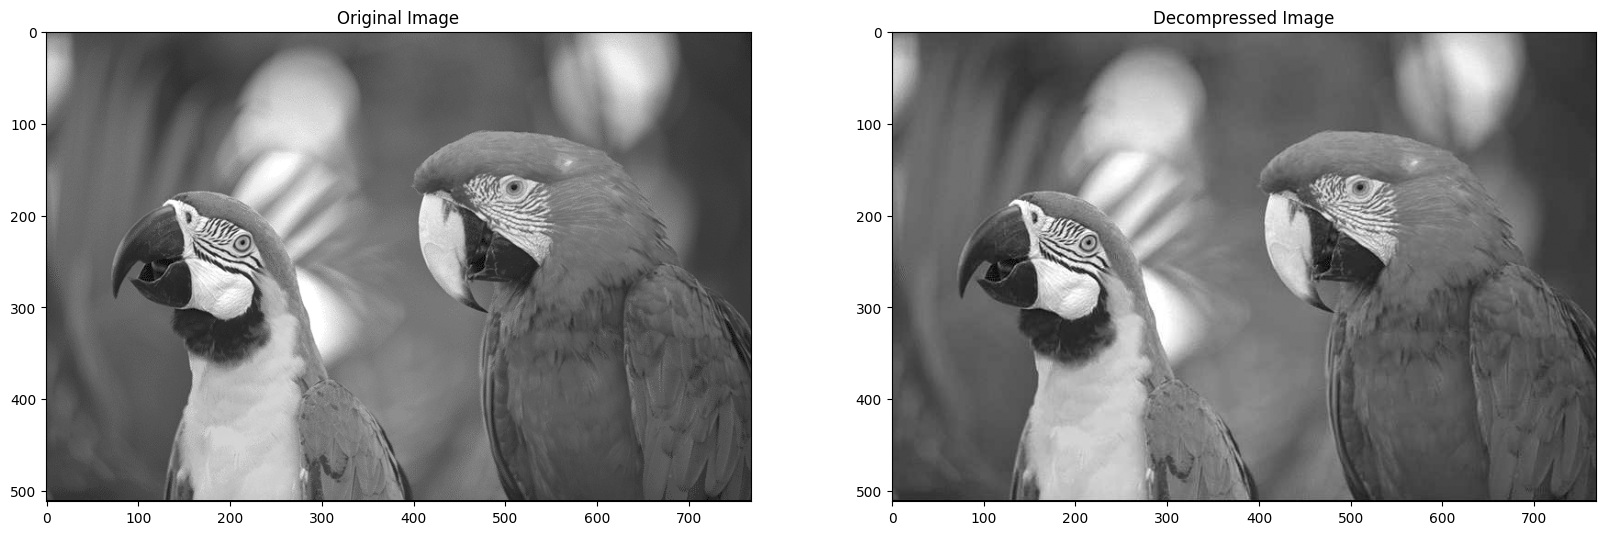

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Decompressed Image")
plt.imshow(decompressed_image, cmap='gray')
plt.show()


In [ ]:
import math

def psnr(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255 / math.sqrt(mse))

compression_ratio = np.count_nonzero(dct_blocks) / np.count_nonzero(quantized_blocks)
psnr_value = psnr(image, decompressed_image)

print(f"Compression Ratio: {compression_ratio:.2f}")
print(f"PSNR: {psnr_value:.2f} dB")


Compression Ratio: 12.19
PSNR: 35.51 dB
